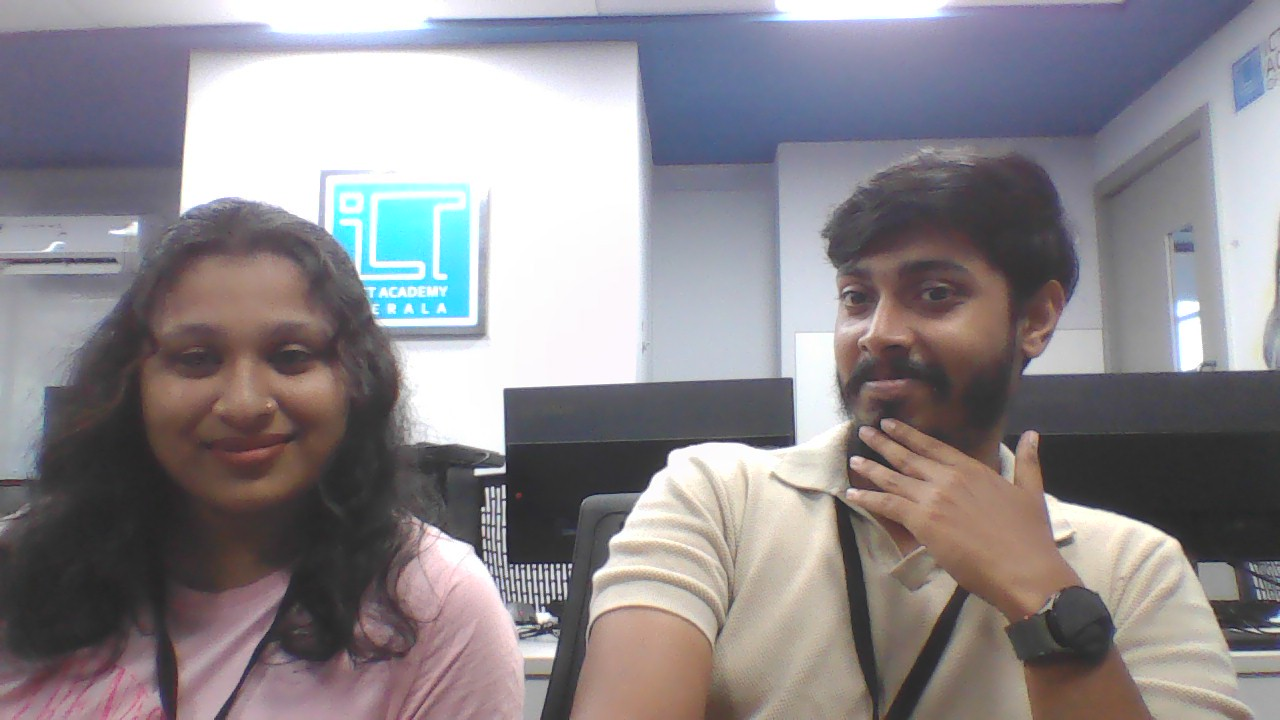

In [23]:
from PIL import Image
import IPython.display

# Path to the image
img_path = '/content/WIN_20260204_13_55_22_Pro.jpg'

# Load and display the image
img = Image.open(img_path)
IPython.display.display(img)

In [24]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from PIL import Image

img_small = img.resize((100, 100))
img_data = np.array(img_small).reshape(-1, 3)

hc = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(img_data)

print(f"Successfully clustered {img_data.shape[0]} pixels.")

Successfully clustered 10000 pixels.


In [25]:
y_hc

array([0, 0, 0, ..., 0, 0, 0])

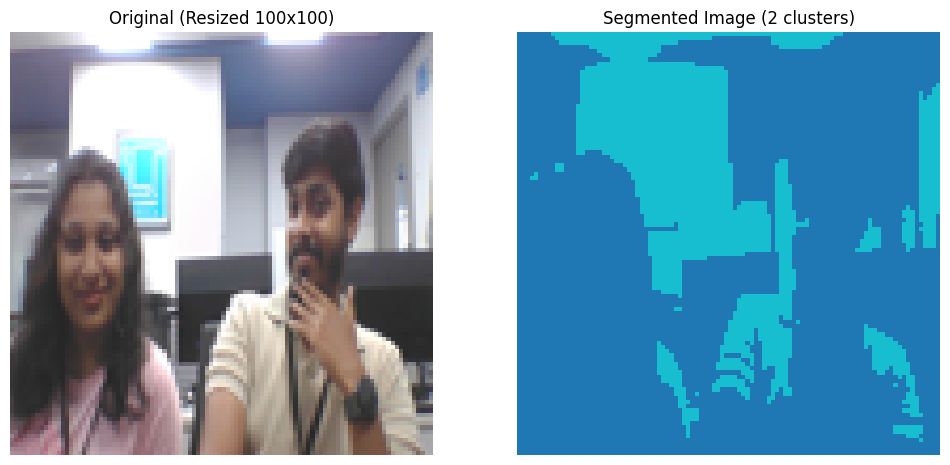

In [26]:

segmented_img = y_hc.reshape(100, 100)

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.imshow(img_small)
plt.title('Original (Resized 100x100)')
plt.axis('off')


plt.subplot(1, 2, 2)

plt.imshow(segmented_img, cmap='tab10')
plt.title('Segmented Image (2 clusters)')
plt.axis('off')

plt.show()

In [27]:
from sklearn.metrics import silhouette_score

s_sc = silhouette_score(img_data, y_hc)
print(f'Silhouette Score: {s_sc}')

Silhouette Score: 0.5818543521047567


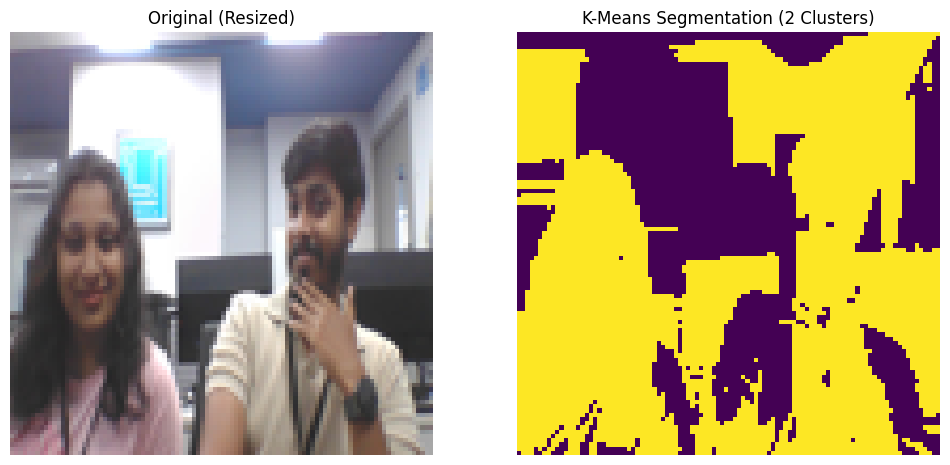

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize and fit KMeans with 5 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
y_kmeans = kmeans.fit_predict(img_data)

# Reshape labels back to image dimensions
segmented_kmeans = y_kmeans.reshape(100, 100)

# Visualize
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_small)
plt.title('Original (Resized)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_kmeans, cmap='viridis')
plt.title('K-Means Segmentation (2 Clusters)')
plt.axis('off')

plt.show()

In [29]:
from sklearn.metrics import silhouette_score

s_sc_kmeans = silhouette_score(img_data, y_kmeans)
print(f'K-Means Silhouette Score: {s_sc_kmeans}')

K-Means Silhouette Score: 0.5756004270721382


Estimated number of clusters: 2
Estimated number of noise points: 11


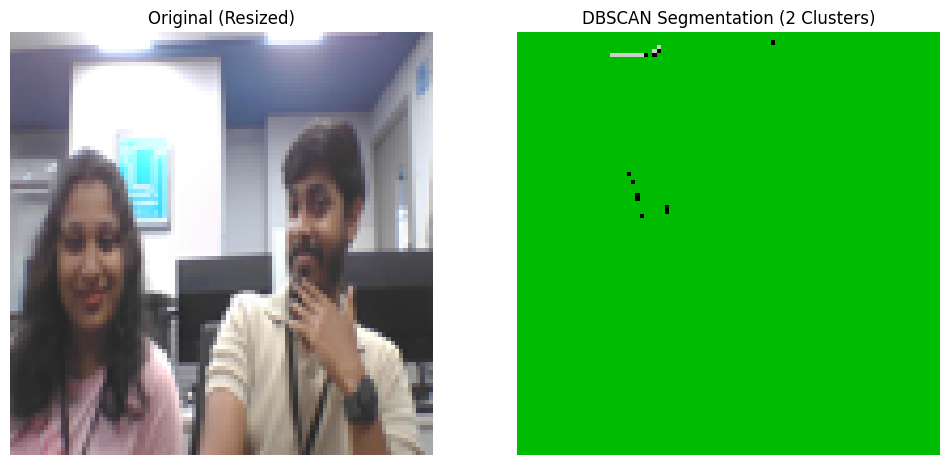

In [44]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Searching for the eps value between 13.0 (3 clusters) and 14.0 (1 cluster).
db = DBSCAN(eps=13.5, min_samples=10)
y_db = db.fit_predict(img_data)

# Reshape labels back to image dimensions (100x100)
segmented_db = y_db.reshape(100, 100)

# Calculate cluster info
n_clusters_ = len(set(y_db)) - (1 if -1 in y_db else 0)
n_noise_ = list(y_db).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

# Visualize the result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_small)
plt.title('Original (Resized)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_db, cmap='nipy_spectral')
plt.title(f'DBSCAN Segmentation ({n_clusters_} Clusters)')
plt.axis('off')

plt.show()

In [45]:
from sklearn.metrics import silhouette_score

s_sc_DBScan = silhouette_score(img_data, y_db)
print(f'DB-Scan Silhouette Score: {s_sc_DBScan}')

DB-Scan Silhouette Score: 0.025244665627096402


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

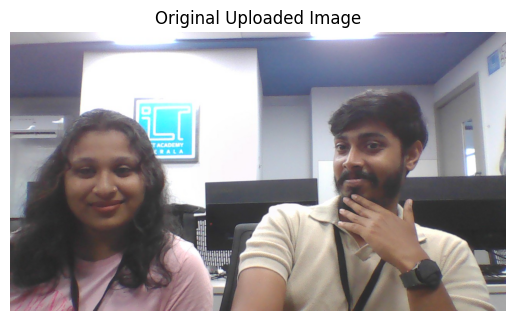

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("/content/WIN_20260204_13_55_22_Pro.jpg")   # <-- change name if needed
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize for speed
img_small = cv2.resize(img, (20, 20))  # 400 pixels only


plt.imshow(img)
plt.title("Original Uploaded Image")
plt.axis("off")

In [73]:
h, w, _ = img_small.shape
X = img_small.reshape(-1, 3).astype(np.float32)

In [ ]:
def custom_agglomerative_safe(X, k=2):
    clusters = [[i] for i in range(len(X))]

    while len(clusters) > k:
        min_dist = np.inf
        pair = (0, 1)

        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                # centroid distance instead of full pairwise
                ci = np.mean(X[clusters[i]], axis=0)
                cj = np.mean(X[clusters[j]], axis=0)
                d = np.linalg.norm(ci - cj)

                if d < min_dist:
                    min_dist = d
                    pair = (i, j)

        clusters[pair[0]] += clusters[pair[1]]
        clusters.pop(pair[1])

    labels = np.zeros(len(X), dtype=int)
    for i, cl in enumerate(clusters):
        for idx in cl:
            labels[idx] = i

    return labels

In [ ]:
labels_agg = custom_agglomerative_safe(X, 2)

seg_agg = X.copy()
seg_agg[labels_agg == 1] = [255, 255, 255]
seg_agg = seg_agg.reshape(h, w, 3).astype(np.uint8)

plt.imshow(seg_agg)
plt.title("Custom Agglomerative (Safe)")
plt.axis("off")


In [78]:
def custom_dbscan(X, eps=20, min_pts=5):
    n = len(X)
    labels = np.full(n, -1)
    cluster_id = 0

    def region_query(i):
        return [j for j in range(n) if np.linalg.norm(X[i] - X[j]) < eps]

    for i in range(n):
        if labels[i] != -1:
            continue

        neighbors = region_query(i)
        if len(neighbors) < min_pts:
            labels[i] = -2  # noise
            continue

        labels[i] = cluster_id
        stack = neighbors[:]

        while stack:
            j = stack.pop()
            if labels[j] == -2:
                labels[j] = cluster_id
            if labels[j] != -1:
                continue

            labels[j] = cluster_id
            new_neighbors = region_query(j)
            if len(new_neighbors) >= min_pts:
                stack.extend(new_neighbors)

        cluster_id += 1

    return labels

(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

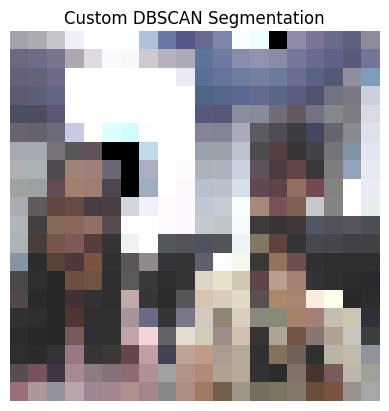

In [79]:
labels_db = custom_dbscan(X, eps=25, min_pts=4)

seg_db = X.copy()
seg_db[labels_db == -2] = [0, 0, 0]  # noise black

seg_db = seg_db.reshape(h, w, 3).astype(np.uint8)

plt.imshow(seg_db)
plt.title("Custom DBSCAN Segmentation")
plt.axis("off")